In [11]:
using Pkg
# Pkg.add("JuMP")
# Pkg.add("HiGHS")
# Pkg.add("Gurobi")
# Pkg.add(url ="https://github.com/rafaelmartinelli/BPPLib.jl")
# Pkg.add("Random")
# Pkg.add("Statistics")
# Pkg.add("Plots")
# Pkg.add("LinearAlgebra")


PART1


In [12]:
using JuMP
# using Gurobi
using HiGHS
using BPPLib
using Random
using Statistics
using Plots

struct Pattern
    x::Vector{Int}
end

function addpattern!(P::Vector{Pattern}, x::Vector{Int})
    if sum(x) == 0
        return
    end
    for p in P
        if p.x == x
            return 
        end
    end
    push!(P, Pattern(copy(x)))
end

function greedy_fill!(r::Vector{Int}, l::Vector{Int}, L::Int)
    n = length(l)
    x = zeros(Int, n)
    used = 0
    while true
        idx = [j for j in 1:n if r[j] > 0 && used + l[j] <= L]
        isempty(idx) && break
        jbest = argmax([(l[j], r[j]) for j in idx])
        j = idx[jbest]
        x[j] += 1
        r[j] -= 1
        used += l[j]
    end
    return x
end

function build_patterns(l::Vector{Int}, d::Vector{Int}, L::Int; m_max::Int=200)
    n = length(l)
    P = Pattern[]

    for j in 1:n
        if l[j] <= L
            x = zeros(Int, n)
            x[j] = 1
            addpattern!(P, x)
        end
    end
    for a in 1:n, b in a:n
        if l[a] + l[b] <= L
            x = zeros(Int, n)
            x[a] += 1
            x[b] += 1
            addpattern!(P, x)
        end
    end
    r = copy(d)
    k = 0
    while k < m_max && sum(r) > 0
        x = greedy_fill!(r, l, L)
        addpattern!(P, x)
        k += 1
    end
    return P
end

function solve_P1(L::Int, l::Vector{Int}, d::Vector{Int}, P::Vector{Pattern};
                  timelimit::Float64=20.0)
    T = length(P)
    model = Model(HiGHS.Optimizer) #Gurobi quand licence ok
    set_silent(model)
    set_attribute(model, "time_limit", timelimit)

    @variable(model, y[1:T] >= 0, Int)
    @objective(model, Min, sum(y[t] for t in 1:T))
    @constraint(model, cover[j=1:length(l)], sum(P[t].x[j]*y[t] for t in 1:T) >= d[j])

    optimize!(model)
    obj = objective_value(model)
    status = termination_status(model)
    time_s = JuMP.MOI.get(model, JuMP.MOI.SolveTimeSec())
    return obj, status, time_s, value.(y)
end

function toy_example()
    L = 5
    l = [2, 2, 3]
    d = [4, 3, 1]
    P = build_patterns(l, d, L; m_max=50)
    obj, status, t, value = solve_P1(L, l, d, P)
    println("  Objective (nbr of long boards used) = ", obj, "   Status = ", status, "   Time = ", round(t, digits=3), " s")
end

toy_example()

  Objective (nbr of long boards used) = 4.0   Status = OPTIMAL   Time = 0.02 s


In [19]:
function solve_all(folder::String)
    files = readdir(folder)
    for file in files
        if endswith(file, ".txt")
            try 
                data = BPPLib.loadCSP(joinpath(folder, file))

                L = Int(data.capacity)
                l = Vector{Int}(data.weights)
                d = Vector{Int}(data.demands)
    
                P = build_patterns(l, d, L; m_max=300)
                obj, status, t, _ = solve_P1(L, l, d, P)
            
                println("  Objective (primal bound): ", obj)
                println("  Status: ", status, " | Time: ", round(t, digits=2), " s")
            catch e
                println("  Error solving instance: ", file, "   Error: ", e)
            end
        end
    end
end

solve_all("Instances/BoardsCutting")


  Objective (primal bound): 500.0
  Status: OPTIMAL | Time: 0.04 s
  Objective (primal bound): 500.0
  Status: OPTIMAL | Time: 0.04 s
  Objective (primal bound): 496.0
  Status: OPTIMAL | Time: 0.05 s
  Objective (primal bound): 496.0
  Status: OPTIMAL | Time: 0.03 s
  Objective (primal bound): 500.0
  Status: OPTIMAL | Time: 0.03 s
  Objective (primal bound): 500.0
  Status: OPTIMAL | Time: 0.03 s
  Objective (primal bound): 500.0
  Status: OPTIMAL | Time: 0.04 s
  Objective (primal bound): 500.0
  Status: OPTIMAL | Time: 0.04 s
  Objective (primal bound): 500.0
  Status: OPTIMAL | Time: 0.03 s
  Objective (primal bound): 498.0
  Status: OPTIMAL | Time: 0.19 s
  Objective (primal bound): 496.0
  Status: OPTIMAL | Time: 0.28 s
  Objective (primal bound): 500.0
  Status: OPTIMAL | Time: 0.04 s
  Objective (primal bound): 500.0
  Status: OPTIMAL | Time: 0.03 s
  Objective (primal bound): 500.0
  Status: OPTIMAL | Time: 0.05 s
  Objective (primal bound): 485.0
  Status: OPTIMAL | Time: 0.

In [14]:
function write_csp_instance(filename::String, name::String, L::Int, l::Vector{Int}, d::Vector{Int})
    open(filename, "w") do io
        println(io, length(l), " ", L)
        for j in 1:length(l)
            println(io, l[j], " ", d[j])
        end
    end
end

function generate_csp_instance(n ::Int=100)
    l = rand(2:30, n)
    d = rand(1:10, n)
    L = Int(round(mean(l) * 4))   #keep patterns feasible
     
    return L, l, d
end

function solve_csp_file(filename::String; m_max::Int=300)
    data = BPPLib.loadCSP(filename)

    L = Int(data.capacity)
    l = Vector{Int}(data.weights)
    d = Vector{Int}(data.demands)
    println("  Capacity = ", L, " | n = ", length(l))

    P = build_patterns(l, d, L; m_max=m_max)
    obj, status, t, _ = solve_P1(L, l, d, P)

    println("  Objective (primal bound): ", obj)
    println("  Status: ", status, " | Time: ", round(t, digits=2), " s")
end

#example
L, l, d = generate_csp_instance(50)
write_csp_instance("temp_instance.txt", "TempInstance", L, l, d)
solve_csp_file("temp_instance.txt")
"""
#Work but take some time to run
sizes = [1,2,5,10,20,30,50,75,100,150,200]
times = Float64[]
for n in sizes
    L, l, d = generate_csp_instance(n)
    write_csp_instance("temp_instance.txt", "TempInstance", L, l, d)
    println("Solving instance of size n = ", n)
    data = BPPLib.loadCSP("temp_instance.txt")
    L = Int(data.capacity)
    l = Vector{Int}(data.weights)
    d = Vector{Int}(data.demands)
    P = build_patterns(l, d, L; m_max=300)
    _, _, t, _ = solve_P1(L, l, d, P)
    push!(times, t)
end
plot(sizes, times, xlabel="Instance Size (n)", ylabel="Time (s)", title="Solving Time", legend=false, marker=:circle)
savefig("csp_solving_time.png")
"""

  Capacity = 61 | n = 50
  Objective (primal bound): 71.0
  Status: OPTIMAL | Time: 0.02 s


"#Work but take some time to run\nsizes = [1,2,5,10,20,30,50,75,100,150,200]\ntimes = Float64[]\nfor n in sizes\n    L, l, d = generate_csp_instance(n)\n    write_csp_instance(\"temp_instance.txt\", \"TempInstance\", L, l, d)\n    println(\"Solving instance of size n = \", n)\n    dat" ⋯ 120 bytes ⋯ "(data.demands)\n    P = build_patterns(l, d, L; m_max=300)\n    _, _, t, _ = solve_P1(L, l, d, P)\n    push!(times, t)\nend\nplot(sizes, times, xlabel=\"Instance Size (n)\", ylabel=\"Time (s)\", title=\"Solving Time\", legend=false, marker=:circle)\nsavefig(\"csp_solving_time.png\")\n"

PART2

In [15]:
using LinearAlgebra

function MILP_method(C)
    m, n = size(C)

    if m > n
        C = hcat(C, zeros(m, m-n))
        n = m
    elseif n > m
        C = vcat(C, zeros(n-m, n))
        m = n
    end

    model = Model(HiGHS.Optimizer)
    set_silent(model)

    @variable(model, x[1:m,1:n], Bin)
    @objective(model, Min, sum(C[i,j]*x[i,j] for i=1:m, j=1:n))
    @constraint(model, [i=1:m], sum(x[i,j] for j=1:n) == 1)
    @constraint(model, [j=1:n], sum(x[i,j] for i=1:m) == 1)

    optimize!(model)

    assign = zeros(Int, m)
    for i in 1:m, j in 1:n
        if value(x[i,j]) > 0.5
            assign[i] = j
        end
    end
    return assign, objective_value(model)
end


#test
C = [4 2 8;
     2 4 6;
     8 6 4]
     
assignment, cost = MILP_method(C)
println("Optimal assignment: ", assignment)

C2 = [4 2 8 3;
      2 4 6 5;
      8 6 4 7]
assignment2, cost2 = MILP_method(C2)
println("Optimal assignment for non-square matrix: ", assignment2)


Optimal assignment: [2, 1, 3]
Optimal assignment for non-square matrix: [2, 1, 3, 4]


In [20]:
using LinearAlgebra

function hungarian_method(C::AbstractMatrix{<:Real})
    m, n = size(C)
    if m > n
        C = hcat(C, zeros(m, m - n))
        n = m
    elseif n > m
        C = vcat(C, zeros(n - m, n))
        m = n
    end
    println("Cost matrix size: ", size(C),C)
    model = Model(HiGHS.Optimizer)
    set_silent(model)

    @variable(model, x[1:m, 1:n], Bin)
    @objective(model, Min, sum(C[i,j] * x[i,j] for i in 1:m, j in 1:n))
    @constraint(model, [i=1:m], sum(x[i,j] for j in 1:n) == 1)
    @constraint(model, [j=1:n], sum(x[i,j] for i in 1:m) == 1)

    optimize!(model)
    assignment = zeros(Int, m)
    for i in 1:m
        for j in 1:n
            if value(x[i,j]) > 0.5
                assignment[i] = j
            end
        end
    end
    return assignment, objective_value(model)
end

C = [4 2 8;
     2 4 6;
     8 6 4]
     
assignment, cost = hungarian_method(C)
println("Optimal assignment: ", assignment)

C2 = [4 2 8 3;
      2 4 6 5;
      8 6 4 7]
assignment2, cost2 = hungarian_method(C2)
println("Optimal assignment for non-square matrix: ", assignment2)


Cost matrix size: (3, 3)[4 2 8; 2 4 6; 8 6 4]
Optimal assignment: [2, 1, 3]
Cost matrix size: (4, 4)[4.0 2.0 8.0 3.0; 2.0 4.0 6.0 5.0; 8.0 6.0 4.0 7.0; 0.0 0.0 0.0 0.0]
Optimal assignment for non-square matrix: [2, 1, 3, 4]


In [ ]:
# Hungarian / Kuhn-Munkres implementation in Julia
# Solves rectangular assignment by padding to square.
# Input: cost matrix `cost` (Float64, size m x n)
# Output: (assignment, total_cost)
#   - assignment: vector of length m, assignment[i] = j assigned to row i (0 if dummy)
#   - total_cost: sum of original costs for assigned pairs
using LinearAlgebra
using BPPLib

function hungarian(cost::Array{Float64,2})
    m, n = size(cost)
    # square dimension
    N = max(m, n)


    C = fill(0.0, N, N)
    C[1:m, 1:n] .= cost

    dummy = N + 1
    u = zeros(Float64, N+1)           # potentials for rows (1..N)
    v = zeros(Float64, N+1)           # potentials for cols (1..N) and v[dummy] used as sentinel
    p = zeros(Int, N+1)               # p[j] = row assigned to column j (j in 1..N or dummy)
    way = zeros(Int, N+1)             # for path reconstruction
    INF = typemax(Float64) / 4.0

    # Main loop: for each row i we build/augment matching
    for i in 1:N
        # initialize for this augmentation
        p[dummy] = i                 # set current row in dummy column
        minv = fill(Inf, N+1)        # minimal reduced cost to each column
        used = falses(N+1)          # visited columns
        used[dummy] = true
        j0 = dummy                  # current column in the tree (start at dummy)
        while true
            i0 = p[j0]              # row corresponding to current column j0
            # find column j1 to extend the tree (choose minimal slack)
            delta = Inf
            j1 = 0
            # examine all real columns 1..N
            for j in 1:N
                if !used[j]
                    # reduced cost
                    cur = C[i0, j] - u[i0] - v[j]
                    if cur < minv[j]
                        minv[j] = cur
                        way[j] = j0
                    end
                    if minv[j] < delta
                        delta = minv[j]
                        j1 = j
                    end
                end
            end

            for jj in 1:(N+1)
                if used[jj]

                    u[p[jj]] += delta
                    v[jj] -= delta
                else
                    minv[jj] -= delta
                end
            end

            # move to new column j1
            j0 = j1
            used[j0] = true

            # if this column is free (no row assigned), we found an augmenting path
            if p[j0] == 0
                break
            end
            # otherwise continue expanding the alternating tree
        end

        # Reconstruct (augment) along the path
        while true
            j1 = way[j0]
            p[j0] = p[j1]    # assign column j0 to the row that was assigned to j1
            j0 = j1
            if j0 == dummy
                break
            end
        end
    end

    assign = zeros(Int, N)     # assign[i] = j assigned to row i (in 1..N)
    for j in 1:N
        if p[j] != 0
            assign[p[j]] = j
        end
    end

    # Extract only original part (rows 1..m, columns 1..n)
    assignment = zeros(Int, m)
    total_cost = 0.0
    for i in 1:m
        j = assign[i]
        if j >= 1 && j <= n
            assignment[i] = j
            total_cost += cost[i, j]
        else
            # assigned to a dummy column -> no real assignment
            assignment[i] = 0
        end
    end

    return assignment, total_cost
end


#Use on all the .dat files in the folder DeliveryAssignment
function solve_assignment_file(filename::String, method_used::Function)

    lines = readlines(filename)

    d_start =  findfirst(contains("Nodes to be delivered"), lines)
    delivered_nodes = parse.(Int, split(lines[d_start+1], ','))

    wh_start = findfirst(contains("Warehouses"), lines)
    warehouses_nodes = parse.(Int, split(lines[wh_start+1], ','))
    
    start = findfirst(contains("Distance matrix"), lines)

    numeric_lines = filter(!isempty, lines[(start+1):end])

    matrix = [parse.(Float64, split(l)) for l in numeric_lines] |> x -> reduce(vcat, permutedims.(x))

    println("  Cost matrix loaded from ", filename)
    m, n = length(delivered_nodes), length(warehouses_nodes)
    C = Array{Float64,2}(undef, m, n)
    for (i, del) in enumerate(delivered_nodes)
        for (j, wh) in enumerate(warehouses_nodes)
            C[i, j] = matrix[del, wh]
        end
    end
    assignment, total_cost = method_used(C)

    println("  Total cost of assignment: ", total_cost)
    println("  Assignment: ", assignment)
end

files = readdir("Instances/DeliveryAssignment")
# println("files: ", files)
for f in files
    if endswith(f, ".dat")
        println("Solving instance: ", f)
        solve_assignment_file(joinpath("Instances/DeliveryAssignment", f), hungarian)
        println("--------------------------------------------------")
    end
end


Solving instance: graph_data_n1000_del100_wh200.dat
  Cost matrix loaded from Instances/DeliveryAssignment/graph_data_n1000_del100_wh200.dat
  Total cost of assignment: 4.142840086539052
  Assignment: [157, 1, 184, 63, 192, 28, 43, 102, 78, 38, 75, 136, 179, 133, 58, 21, 153, 4, 175, 92, 18, 149, 197, 45, 15, 81, 19, 91, 68, 127, 104, 132, 150, 90, 130, 196, 59, 122, 79, 191, 86, 138, 54, 47, 172, 154, 146, 30, 190, 26, 116, 155, 5, 134, 41, 145, 33, 128, 113, 77, 44, 34, 70, 141, 29, 117, 167, 64, 108, 69, 49, 148, 20, 142, 55, 165, 95, 162, 10, 173, 97, 166, 144, 171, 125, 22, 137, 174, 16, 56, 124, 73, 158, 100, 118, 135, 23, 12, 195, 50]
--------------------------------------------------
Solving instance: graph_data_n1000_del100_wh250.dat
  Cost matrix loaded from Instances/DeliveryAssignment/graph_data_n1000_del100_wh250.dat
  Total cost of assignment: 3.511523858834476
  Assignment: [201, 20, 235, 237, 50, 9, 67, 120, 33, 86, 76, 181, 82, 165, 91, 212, 131, 158, 185, 27, 196, 216

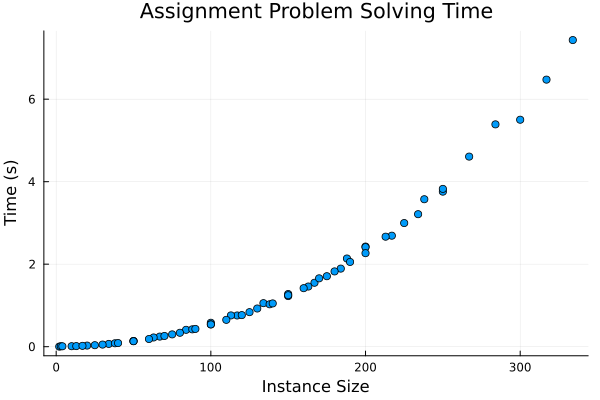

In [23]:
sizes = Int[]
times = Float64[]
files = readdir("Instances/DeliveryAssignment")
for file in files
    if endswith(file, ".dat")
        #println("\nSolving assignment problem from file: ", file)
        try
            lines = readlines(joinpath("Instances/DeliveryAssignment", file))

            d_start =  findfirst(contains("Nodes to be delivered"), lines)
            delivered_nodes = parse.(Int, split(lines[d_start+1], ','))
            m = length(delivered_nodes)

            wh_start = findfirst(contains("Warehouses"), lines)
            warehouses_nodes = parse.(Int, split(lines[wh_start+1], ','))
            n = length(warehouses_nodes)

            start = findfirst(contains("Distance matrix"), lines)
            numeric_lines = filter(!isempty, lines[(start+1):end])
            matrix = [parse.(Float64, split(l)) for l in numeric_lines] |> x -> reduce(vcat, permutedims.(x))

            C = Array{Float64,2}(undef, m, n)
            for (i, del) in enumerate(delivered_nodes)
                for (j, wh) in enumerate(warehouses_nodes)
                    C[i, j] = matrix[del, wh]
                end
            end  

            t_start = time()
            assignment, total_cost = MILP_method(C)
            t_end = time()
            t_solve = t_end - t_start

            #println("  Total cost of assignment: ", total_cost)
            #println("  Assignment: ", assignment)
            #println("  Time taken: ", round(t_solve, digits=3), " s")

            push!(sizes, max(m,n))
            push!(times, t_solve)
            plot(sizes, times, xlabel="Instance Size", ylabel="Time (s)", title="Assignment Problem Solving Time", legend=false, marker=:circle)
        catch e
            println("  Error solving instance: ", file, "   Error: ", e)
        end
    end
end

plot(sizes, times,seriestype = :scatter, xlabel="Instance Size", ylabel="Time (s)", title="Assignment Problem Solving Time", legend=false, marker=:circle)